<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/example%20Vanilla%20Federated%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install tensorflow --quiet

In [2]:


# Import necessary libraries
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [6]:


class DeepRegressionTree(tf.keras.Model):
    """
    A simplified deep regression tree that combines neural network layers
    with tree-like decision making for federated learning
    """
    def __init__(self, input_dim, hidden_units=[64, 32], max_depth=3):
        super(DeepRegressionTree, self).__init__()
        self.max_depth = max_depth

        # Neural network layers for feature transformation
        self.hidden_layers = []
        prev_units = input_dim
        for units in hidden_units:
            self.hidden_layers.append(
                tf.keras.layers.Dense(units, activation='relu')
            )
            prev_units = units

        # Output layers for each depth level
        self.output_layers = []
        for depth in range(max_depth):
            self.output_layers.append(
                tf.keras.layers.Dense(1, activation=None)  # No activation for regression
            )

        # Gating network to decide which path to take
        self.gating_network = tf.keras.layers.Dense(max_depth, activation='softmax')

    def call(self, inputs):
        x = inputs

        # Pass through hidden layers
        for layer in self.hidden_layers:
            x = layer(x)

        # Get gating weights for different depths
        gating_weights = self.gating_network(x)

        # Compute outputs at each depth
        outputs = []
        for output_layer in self.output_layers:
            outputs.append(output_layer(x))

        # Combine outputs using gating weights
        outputs = tf.stack(outputs, axis=1)  # Shape: [batch_size, max_depth, 1]
        weighted_output = tf.reduce_sum(outputs * tf.expand_dims(gating_weights, axis=-1), axis=1)

        return tf.squeeze(weighted_output, axis=-1)

class FederatedDeepRegressionForest:
    """
    Federated Deep Regression Forest implementation
    """
    def __init__(self, n_clients=5, input_dim=10, hidden_units=[64, 32], max_depth=3):
        self.n_clients = n_clients
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.max_depth = max_depth

        # Initialize models for each client
        self.client_models = []
        for i in range(n_clients):
            model = DeepRegressionTree(input_dim, hidden_units, max_depth)
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            # Build the model by running a dummy forward pass
            _ = model(tf.zeros((1, input_dim)))
            self.client_models.append(model)

        # Global model (aggregated model)
        self.global_model = DeepRegressionTree(input_dim, hidden_units, max_depth)
        self.global_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        # Build the global model by running a dummy forward pass
        _ = self.global_model(tf.zeros((1, input_dim)))

    def distribute_model_weights(self):
        """Distribute global model weights to all clients"""
        global_weights = self.global_model.get_weights()
        for client_model in self.client_models:
            client_model.set_weights(global_weights)

    def aggregate_weights(self):
        """Aggregate client model weights using federated averaging"""
        # Collect weights from all clients
        all_weights = []
        for client_model in self.client_models:
            all_weights.append(client_model.get_weights())

        # Average the weights
        avg_weights = []
        for layer_idx in range(len(all_weights[0])):
            layer_weights = np.array([weights[layer_idx] for weights in all_weights])
            avg_layer_weights = np.mean(layer_weights, axis=0)
            avg_weights.append(avg_layer_weights)

        # Update global model
        self.global_model.set_weights(avg_weights)

    def train_client(self, client_id, X, y, epochs=10):
        """Train a specific client model"""
        model = self.client_models[client_id]
        history = model.fit(X, y, epochs=epochs, verbose=0)
        return history

    def federated_train(self, X_clients, y_clients, rounds=10, epochs_per_round=5):
        """Perform federated training"""
        loss_history = []

        for round_num in range(rounds):
            print(f"Round {round_num + 1}/{rounds}")

            # Distribute global model to all clients
            self.distribute_model_weights()

            # Train each client on their local data
            for client_id in range(self.n_clients):
                X_client = X_clients[client_id]
                y_client = y_clients[client_id]

                self.train_client(client_id, X_client, y_client, epochs=epochs_per_round)

            # Aggregate weights to form new global model
            self.aggregate_weights()

            # Evaluate global model on a validation set (using first client's data as example)
            val_loss, val_mae = self.global_model.evaluate(X_clients[0], y_clients[0], verbose=0)
            loss_history.append((val_loss, val_mae))

            print(f"  Global model - Loss: {val_loss:.4f}, MAE: {val_mae:.4f}")

        return loss_history

def create_federated_dataset(X, y, n_clients=5):
    """Split dataset into federated clients"""
    # Shuffle the data
    indices = np.random.permutation(len(X))
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    # Split data among clients
    n_samples = len(X)
    samples_per_client = n_samples // n_clients

    X_clients = []
    y_clients = []

    for i in range(n_clients):
        start_idx = i * samples_per_client
        if i == n_clients - 1:  # Last client gets remaining samples
            end_idx = n_samples
        else:
            end_idx = (i + 1) * samples_per_client

        X_clients.append(X_shuffled[start_idx:end_idx])
        y_clients.append(y_shuffled[start_idx:end_idx])

    return X_clients, y_clients



This creates a synthetic regression dataset with:

* 1000 samples
* 10 features (multivariate regression)
* Continuous target values (regression problem)
* Controlled noise level (0.1)

Synthetic data mimics real-world situations where data is distributed across multiple sources


In [7]:
# Generate synthetic regression dataset
print("Generating synthetic dataset...")
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create federated dataset (split training data among clients)
X_clients, y_clients = create_federated_dataset(X_train, y_train, n_clients=5)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Number of clients: {len(X_clients)}")
for i, (X_c, y_c) in enumerate(zip(X_clients, y_clients)):
    print(f"Client {i}: {X_c.shape[0]} samples")

Generating synthetic dataset...
Training data shape: (800, 10)
Test data shape: (200, 10)
Number of clients: 5
Client 0: 160 samples
Client 1: 160 samples
Client 2: 160 samples
Client 3: 160 samples
Client 4: 160 samples



Initializing Federated Deep Regression Forest...

Starting federated training...
Round 1/10
  Global model - Loss: 18756.6836, MAE: 108.2397
Round 2/10
  Global model - Loss: 18486.0996, MAE: 107.4372
Round 3/10
  Global model - Loss: 17718.3242, MAE: 104.8736
Round 4/10
  Global model - Loss: 16399.2617, MAE: 99.9441
Round 5/10
  Global model - Loss: 14510.9902, MAE: 92.2613
Round 6/10
  Global model - Loss: 12032.9072, MAE: 81.5876
Round 7/10
  Global model - Loss: 9150.4590, MAE: 68.4461
Round 8/10
  Global model - Loss: 6361.5000, MAE: 55.1434
Round 9/10
  Global model - Loss: 4318.6367, MAE: 45.7970
Round 10/10
  Global model - Loss: 3171.9924, MAE: 41.4862

Evaluating final global model...
Final Global Model - Train Loss: 2912.7510, Train MAE: 41.1506
Final Global Model - Test Loss: 2888.6768, Test MAE: 42.0344


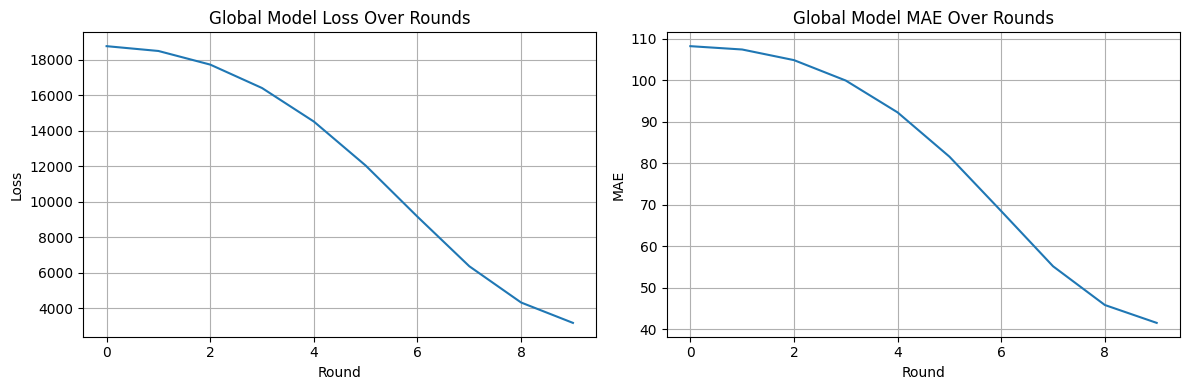

In [8]:

# Initialize federated deep regression forest
print("\nInitializing Federated Deep Regression Forest...")
forest = FederatedDeepRegressionForest(
    n_clients=5,
    input_dim=X_train.shape[1],
    hidden_units=[64, 32],
    max_depth=3
)

# Perform federated training
print("\nStarting federated training...")
loss_history = forest.federated_train(X_clients, y_clients, rounds=10, epochs_per_round=5)

# Evaluate the final global model
print("\nEvaluating final global model...")
train_loss, train_mae = forest.global_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = forest.global_model.evaluate(X_test, y_test, verbose=0)

print(f"Final Global Model - Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Final Global Model - Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Plot training progress
loss_vals, mae_vals = zip(*loss_history)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_vals)
plt.title('Global Model Loss Over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mae_vals)
plt.title('Global Model MAE Over Rounds')
plt.xlabel('Round')
plt.ylabel('MAE')
plt.grid(True)

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


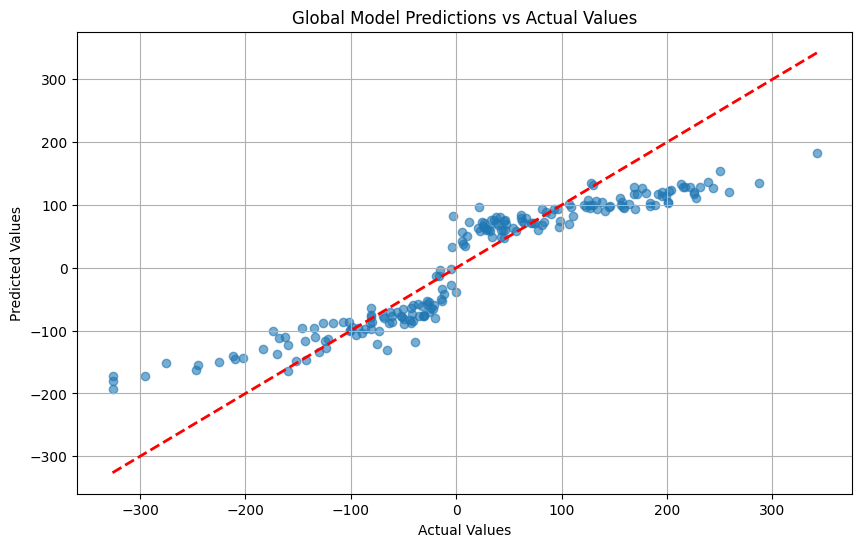


Final Metrics:
MSE: 2888.6767
RMSE: 53.7464
R² Score: 0.8288


In [9]:


# Make predictions with the global model
predictions = forest.global_model.predict(X_test)

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Global Model Predictions vs Actual Values')
plt.grid(True)
plt.show()

# Calculate and print metrics
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"\nFinal Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"R² Score: {r2:.4f}")

# Federated Learning with tracking


Creating forest with weight tracking...

Starting federated training with weight tracking...
Round 1/5
  Global model - Loss: 18812.8555, MAE: 108.3859
Round 2/5
  Global model - Loss: 18704.8789, MAE: 108.0628
Round 3/5
  Global model - Loss: 18530.5059, MAE: 107.5084
Round 4/5
  Global model - Loss: 18253.4902, MAE: 106.6184
Round 5/5
  Global model - Loss: 17804.4648, MAE: 105.1180

Visualizing weight distributions...


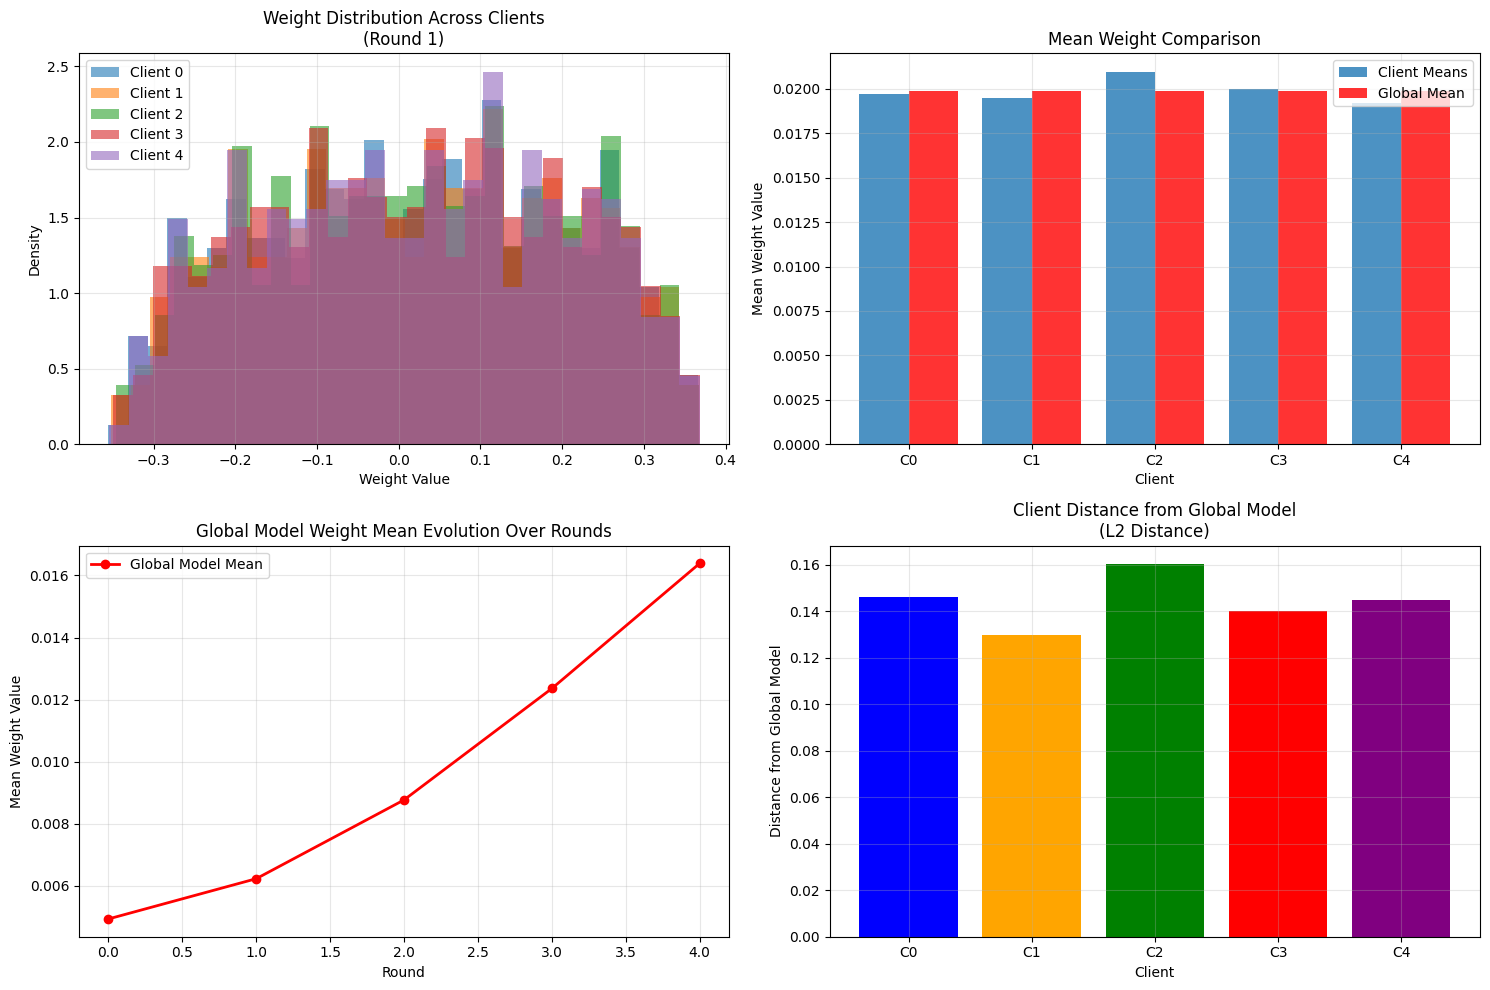


Visualizing federated learning process...


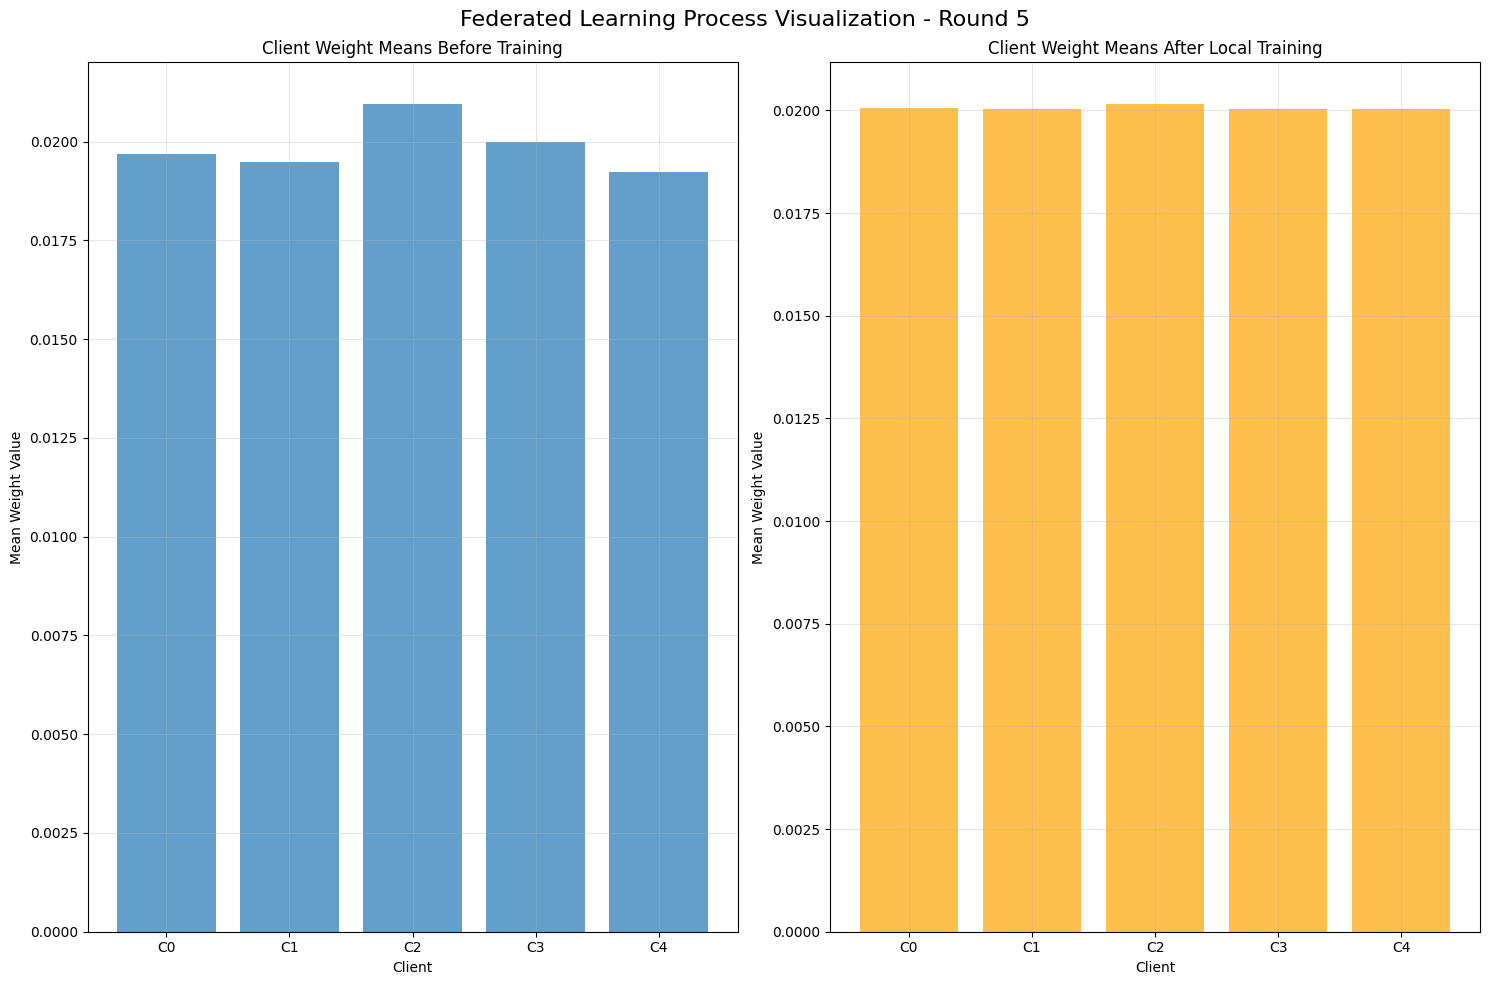


Plotting performance convergence...


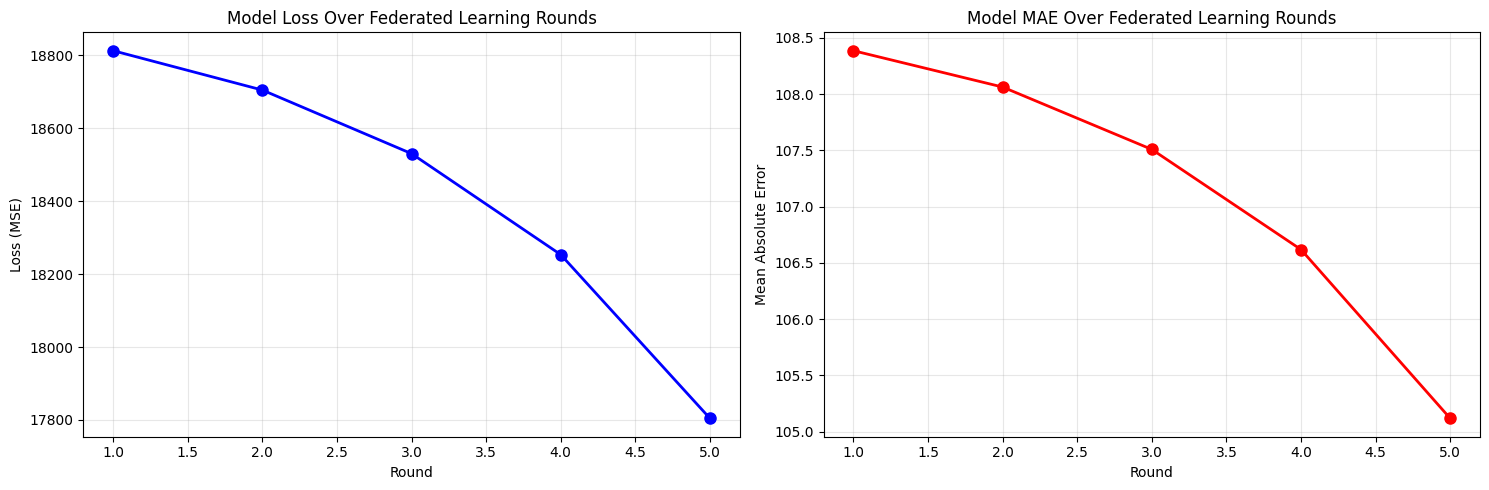


Plotting weight variance evolution...


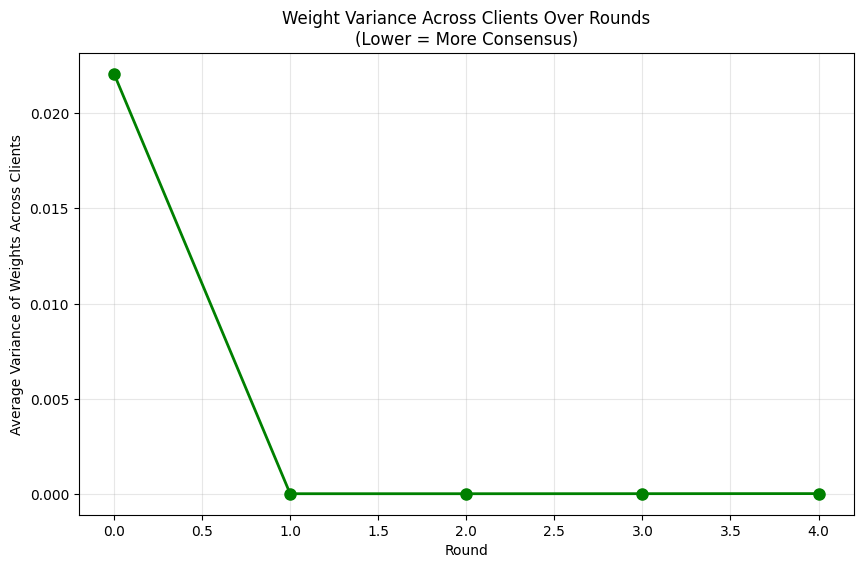


Training completed!
Number of training rounds: 5
Number of clients: 5
Final global model loss: 17804.4648
Final global model MAE: 105.1180
Global weight history length: 5
Client weight history length: 5


In [38]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_weight_distributions(forest, round_num=0):
    """
    More realistic visualization of federated learning weight distributions
    """
    # Get weights from all clients and global model
    all_weights = [model.get_weights() for model in forest.client_models]
    global_weights = forest.global_model.get_weights()

    # Focus on the first dense layer weights for visualization
    client_layer_weights = []
    for client_weights in all_weights:
        # Get weights from the first dense layer (the first weight matrix)
        layer_weights = client_weights[0]  # Shape: [input_dim, hidden_units[0]]
        # Flatten to 1D for histogram
        client_layer_weights.append(layer_weights.flatten())

    # Flatten global weights for comparison
    global_layer_weights = global_weights[0].flatten()

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Distribution of weights in each client
    for i, weights in enumerate(client_layer_weights):
        axes[0, 0].hist(weights, bins=30, alpha=0.6, label=f'Client {i}', density=True)
    axes[0, 0].set_title('Weight Distribution Across Clients\n(Round {})'.format(round_num))
    axes[0, 0].set_xlabel('Weight Value')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Comparison of global vs client weights (means)
    client_means = [np.mean(weights) for weights in client_layer_weights]
    client_stds = [np.std(weights) for weights in client_layer_weights]

    x_pos = np.arange(len(client_means))
    axes[0, 1].bar(x_pos - 0.2, client_means, 0.4, label='Client Means', alpha=0.8)
    axes[0, 1].bar(x_pos + 0.2, [np.mean(global_layer_weights)] * len(client_means),
                   0.4, label='Global Mean', alpha=0.8, color='red')
    axes[0, 1].set_xlabel('Client')
    axes[0, 1].set_ylabel('Mean Weight Value')
    axes[0, 1].set_title('Mean Weight Comparison')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels([f'C{i}' for i in range(len(client_means))])

    # Plot 3: Weight convergence over rounds (if we store history)
    if hasattr(forest, 'global_weight_history') and len(forest.global_weight_history) > 1:
        rounds = range(len(forest.global_weight_history))
        global_means = [np.mean(weights[0]) for weights in forest.global_weight_history]

        # Plot global model mean evolution
        axes[1, 0].plot(rounds, global_means, 'ro-', label='Global Model Mean', linewidth=2)
        axes[1, 0].set_title('Global Model Weight Mean Evolution Over Rounds')
        axes[1, 0].set_xlabel('Round')
        axes[1, 0].set_ylabel('Mean Weight Value')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Run multiple rounds\nto see convergence',
                        horizontalalignment='center', verticalalignment='center',
                        transform=axes[1, 0].transAxes, fontsize=14)
        axes[1, 0].set_title('Global Model Evolution')

    # Plot 4: Client model distance from global model
    distances_from_global = []
    for client_weights in client_layer_weights:
        # Calculate L2 distance from global weights
        dist = np.linalg.norm(client_weights - global_layer_weights)
        distances_from_global.append(dist)

    axes[1, 1].bar(range(len(distances_from_global)), distances_from_global,
                   color=['blue', 'orange', 'green', 'red', 'purple'][:len(distances_from_global)])
    axes[1, 1].set_xlabel('Client')
    axes[1, 1].set_ylabel('Distance from Global Model')
    axes[1, 1].set_title('Client Distance from Global Model\n(L2 Distance)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(range(len(distances_from_global)))
    axes[1, 1].set_xticklabels([f'C{i}' for i in range(len(distances_from_global))])

    plt.tight_layout()
    plt.show()

def visualize_federated_process(forest, round_num):
    """
    Visualize the federated learning process
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))

    # Get current weights
    client_weights_before = [model.get_weights() for model in forest.client_models]

    # Simulate the federated process with actual training
    # First, distribute global weights
    forest.distribute_model_weights()

    # Then simulate training on each client
    for client_id in range(forest.n_clients):
        # Use a small subset of data for quick training simulation
        X_sample = X_clients[client_id][:50] if len(X_clients[client_id]) > 50 else X_clients[client_id]
        y_sample = y_clients[client_id][:50] if len(y_clients[client_id]) > 50 else y_clients[client_id]

        if len(X_sample) > 0:  # Only train if we have data
            forest.client_models[client_id].train_on_batch(X_sample[:10], y_sample[:10])  # Quick training

    # Get weights after training
    client_weights_after = [model.get_weights() for model in forest.client_models]

    # Perform aggregation
    forest.aggregate_weights()
    global_weights_after = forest.global_model.get_weights()

    # Plot 1: Client weights before training
    client_means_before = [np.mean(weights[0]) for weights in client_weights_before]
    axes[0].bar(range(len(client_means_before)), client_means_before,
                   alpha=0.7, label='Before Training')
    axes[0].set_title('Client Weight Means Before Training')
    axes[0].set_xlabel('Client')
    axes[0].set_ylabel('Mean Weight Value')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(range(len(client_means_before)))
    axes[0].set_xticklabels([f'C{i}' for i in range(len(client_means_before))])

    # Plot 2: Client weights after local training
    client_means_after = [np.mean(weights[0]) for weights in client_weights_after]
    axes[1].bar(range(len(client_means_after)), client_means_after,
                   alpha=0.7, label='After Local Training', color='orange')
    axes[1].set_title('Client Weight Means After Local Training')
    axes[1].set_xlabel('Client')
    axes[1].set_ylabel('Mean Weight Value')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticks(range(len(client_means_after)))
    axes[1].set_xticklabels([f'C{i}' for i in range(len(client_means_after))])



    plt.suptitle(f'Federated Learning Process Visualization - Round {round_num}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Modified FederatedDeepRegressionForest to properly track both client and global weight evolution
class FederatedDeepRegressionForestWithTracking(FederatedDeepRegressionForest):
    def __init__(self, n_clients=5, input_dim=10, hidden_units=[64, 32], max_depth=3):
        super().__init__(n_clients, input_dim, hidden_units, max_depth)
        self.client_weight_history = []  # Track client weight evolution
        self.global_weight_history = []  # Track global weight evolution

    def federated_train(self, X_clients, y_clients, rounds=10, epochs_per_round=5):
        """Perform federated training with weight tracking"""
        loss_history = []

        for round_num in range(rounds):
            print(f"Round {round_num + 1}/{rounds}")

            # Store current client weights BEFORE local training
            current_client_weights = [client_model.get_weights() for client_model in self.client_models]
            self.client_weight_history.append(current_client_weights)

            # Store current global weights
            current_global_weights = self.global_model.get_weights()
            self.global_weight_history.append(current_global_weights)

            # Distribute global model to all clients
            self.distribute_model_weights()

            # Train each client on their local data
            for client_id in range(self.n_clients):
                X_client = X_clients[client_id]
                y_client = y_clients[client_id]

                # Train for a few epochs
                self.client_models[client_id].fit(X_client, y_client,
                                                 epochs=epochs_per_round, verbose=0)

            # Aggregate weights to form new global model
            self.aggregate_weights()

            # Evaluate global model on a validation set (using first client's data as example)
            val_loss, val_mae = self.global_model.evaluate(X_clients[0], y_clients[0], verbose=0)
            loss_history.append((val_loss, val_mae))

            print(f"  Global model - Loss: {val_loss:.4f}, MAE: {val_mae:.4f}")

        return loss_history

# Additional visualization: Model performance convergence
def plot_performance_convergence(forest, loss_history):
    """
    Plot model performance over federated learning rounds
    """
    if not loss_history:
        print("No loss history to plot")
        return

    rounds = range(1, len(loss_history) + 1)
    losses, maes = zip(*loss_history)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss over rounds
    ax1.plot(rounds, losses, 'b-o', linewidth=2, markersize=8)
    ax1.set_title('Model Loss Over Federated Learning Rounds')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Loss (MSE)')
    ax1.grid(True, alpha=0.3)

    # Plot MAE over rounds
    ax2.plot(rounds, maes, 'r-o', linewidth=2, markersize=8)
    ax2.set_title('Model MAE Over Federated Learning Rounds')
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Additional visualization: Weight variance over time
def plot_weight_variance_evolution(forest):
    """
    Plot how weight variance across clients evolves over rounds
    """
    if not hasattr(forest, 'client_weight_history') or len(forest.client_weight_history) < 2:
        print("Not enough data for variance analysis. Run more rounds.")
        return

    rounds = range(len(forest.client_weight_history))
    variance_over_time = []

    for round_weights in forest.client_weight_history:
        # Calculate variance of weights across clients for the first layer
        client_first_layer_weights = [weights[0] for weights in round_weights]

        # Calculate element-wise variance across clients
        stacked_weights = np.stack(client_first_layer_weights, axis=0)  # Shape: [n_clients, weight_matrix_shape]
        variance_across_clients = np.var(stacked_weights, axis=0)  # Variance for each weight
        avg_variance = np.mean(variance_across_clients)  # Average variance
        variance_over_time.append(avg_variance)

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, variance_over_time, 'g-o', linewidth=2, markersize=8)
    plt.title('Weight Variance Across Clients Over Rounds\n(Lower = More Consensus)')
    plt.xlabel('Round')
    plt.ylabel('Average Variance of Weights Across Clients')
    plt.grid(True, alpha=0.3)
    plt.show()

# Create a new forest with tracking
print("\nCreating forest with weight tracking...")
forest_with_tracking = FederatedDeepRegressionForestWithTracking(
    n_clients=5,
    input_dim=X_train.shape[1],
    hidden_units=[64, 32],
    max_depth=3
)

# Run federated training with tracking
print("\nStarting federated training with weight tracking...")
loss_history = forest_with_tracking.federated_train(X_clients, y_clients, rounds=5, epochs_per_round=3)

# Visualize weight distributions
print("\nVisualizing weight distributions...")
visualize_weight_distributions(forest_with_tracking, round_num=1)

# Visualize federated process
print("\nVisualizing federated learning process...")
visualize_federated_process(forest_with_tracking, round_num=5)

# Plot performance convergence
print("\nPlotting performance convergence...")
plot_performance_convergence(forest_with_tracking, loss_history)

# Plot weight variance evolution
print("\nPlotting weight variance evolution...")
plot_weight_variance_evolution(forest_with_tracking)

# Print some statistics
print(f"\nTraining completed!")
print(f"Number of training rounds: 5")
print(f"Number of clients: {forest_with_tracking.n_clients}")
print(f"Final global model loss: {loss_history[-1][0]:.4f}")
print(f"Final global model MAE: {loss_history[-1][1]:.4f}")
print(f"Global weight history length: {len(forest_with_tracking.global_weight_history)}")
print(f"Client weight history length: {len(forest_with_tracking.client_weight_history)}")


Visualizing federated learning process diagram...


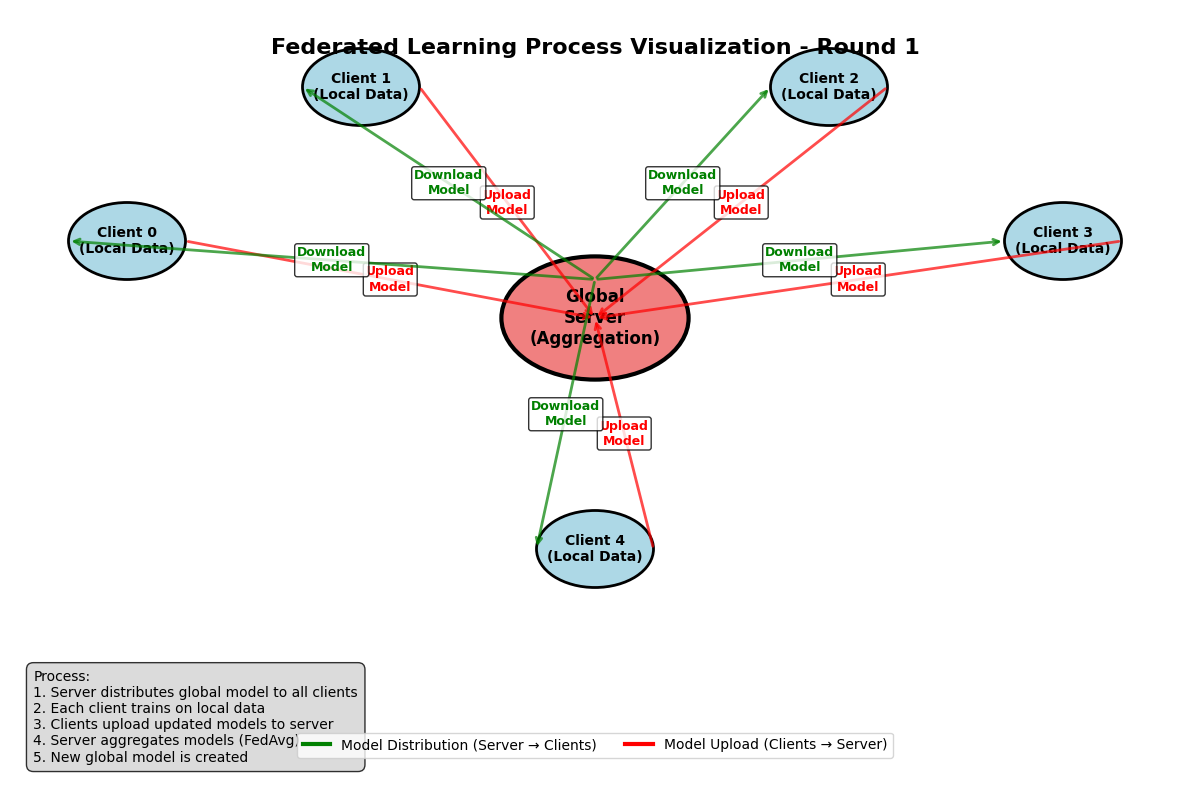

In [33]:
def visualize_federated_process_diagram(forest, round_num):
    """
    Visualize the federated learning process as a single diagram
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.clear()
    ax.axis('off')

    # Title
    ax.text(0.5, 0.95, f'Federated Learning Process Visualization - Round {round_num}',
            ha='center', va='center', fontsize=16, fontweight='bold', transform=ax.transAxes)

    # Draw federated learning diagram
    # Clients (positioned in a circle around the server)
    client_positions = [(0.1, 0.7), (0.3, 0.9), (0.7, 0.9), (0.9, 0.7), (0.5, 0.3)]

    for i, (x, y) in enumerate(client_positions):
        # Client circle
        circle = plt.Circle((x, y), 0.05, color='lightblue', ec='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(x, y, f'Client {i}\n(Local Data)', ha='center', va='center',
                fontweight='bold', fontsize=10)

    # Global server (center)
    server_x, server_y = 0.5, 0.6
    server_circle = plt.Circle((server_x, server_y), 0.08, color='lightcoral', ec='black', linewidth=3)
    ax.add_patch(server_circle)
    ax.text(server_x, server_y, 'Global\nServer\n(Aggregation)', ha='center', va='center',
            fontweight='bold', fontsize=12)

    # Arrows showing communication
    for i, (x, y) in enumerate(client_positions):
        # Client to server (uploading model after local training)
        ax.annotate('', xy=(server_x, server_y), xytext=(x+0.05, y),
                   arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.7))
        ax.text((x+0.05+server_x)/2, (y+server_y)/2, 'Upload\nModel',
                ha='center', va='center', fontsize=9, color='red', weight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

        # Server to client (distributing global model)
        ax.annotate('', xy=(x-0.05, y), xytext=(server_x, server_y+0.05),
                   arrowprops=dict(arrowstyle='->', color='green', lw=2, alpha=0.7))
        ax.text((x-0.05+server_x)/2, (y+server_y+0.05)/2, 'Download\nModel',
                ha='center', va='center', fontsize=9, color='green', weight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

    # Legend
    legend_elements = [
        plt.Line2D([0], [0], color='green', lw=3, label='Model Distribution (Server → Clients)'),
        plt.Line2D([0], [0], color='red', lw=3, label='Model Upload (Clients → Server)')
    ]
    ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=2)

    # Process explanation text
    explanation_text = (
        "Process:\n"
        "1. Server distributes global model to all clients\n"
        "2. Each client trains on local data\n"
        "3. Clients upload updated models to server\n"
        "4. Server aggregates models (FedAvg)\n"
        "5. New global model is created"
    )
    ax.text(0.02, 0.02, explanation_text, fontsize=10,
            verticalalignment='bottom', bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Call the new visualization function
print("\nVisualizing federated learning process diagram...")
visualize_federated_process_diagram(forest_with_tracking, round_num=1)